In [9]:
from __future__ import print_function
import os
import sys
import math
import pickle
import pdb
import argparse
import random
from tqdm import tqdm
from shutil import copy
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from scipy.linalg import qr 
import igraph as ig
from random import shuffle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from util import *
from modelsRIGHT import *
from igraph import *
import networkx as nx
from collections import Counter
import importlib
from sklearn.decomposition import PCA
from dotmap import DotMap
import pandas as pd
import json
from scipy.stats import wasserstein_distance
import csv
from pathlib import Path
import re
import visualize_util
from visualize_util import *




In [10]:
p = os.path.join("vertex_4_6dim_latent_KL0.01_NObatch_hs256","final_structures6_2")

model_dir = os.path.join(p, "model")
print(model_dir)
files = [os.path.join(model_dir, file) for file in os.listdir(model_dir)]
file_dict = {int(re.findall(r'\d+', Path(file).name)[0]):file for file in files}
f_l = [int(re.findall(r'\d+', Path(file).name)[0]) for file in files]
max_epoch = max(file_dict.keys())

last_epoch = file_dict[max_epoch]

# max_epoch = 15
# last_epoch = os.path.join(model_dir,"model_checkpoint"+str(max_epoch)+".pth")
print(last_epoch)

vis_path = os.path.join(p, "evaluation", str(max_epoch))
csv_file_path = "summary.csv"
if( not os.path.exists(vis_path)):
    os.makedirs(vis_path)
argsFile = os.path.join(p,"cmd_input.txt")
with open(argsFile) as f:
    argsJSON = json.load(f)
args = DotMap(argsJSON)


vertex_4_6dim_latent_KL0.01_NObatch_hs256\final_structures6_2\model
vertex_4_6dim_latent_KL0.01_NObatch_hs256\final_structures6_2\model\model_checkpoint341.pth


In [11]:
# df = pd.read_csv("vertex_4_2dim_latent_batchnorm2\\final_structures6\\train_loss.txt", sep= " ")
# df2 = pd.read_csv("vertex_4_4dim_latent\\final_structures6\\train_loss.txt", sep= " ")
# df3 = pd.read_csv("train_lossBIG.txt", sep= " ")
# df4 = pd.read_csv("vertex_4_2dimLatent_new\\final_structures6\\train_loss.txt", sep= " ")
df5 = pd.read_csv(os.path.join(p,"train_loss.txt"), sep= " ")

ix=df5.iloc[:,[0,2]].sum(1).idxmin()
print(ix)
# print(df5.iloc[[300]])


0


<Figure size 600x400 with 0 Axes>

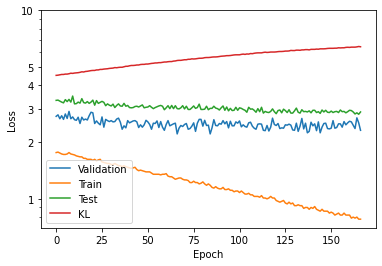

In [12]:
plt.figure(dpi = 100)
fig1, ax1 = plt.subplots()
ax1.plot(df5.iloc[:,3], label='Validation')
ax1.plot(df5.iloc[:,0], label='Train')
ax1.plot(df5.iloc[:,4], label='Test')
ax1.plot(df5.iloc[:,2], label='KL')
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_yscale('log')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')


ax1.legend()
ax1.set_yticks([10,5,4,3,2,1])
ax1.set_yticklabels([10,5,4,3,2,1])
ax1.get_yaxis().get_major_formatter().labelOnlyBase = False
# plt.plot(df3.iloc[:2949,4], label='Total')

In [13]:

print(args.seed)
print(args)
print(type(args.seed))
args.cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
np.random.seed(args.seed)
random.seed(args.seed)
print(device)
print(sys.version)


1
DotMap(data_type='BN', data_name='final_structures6', nvt=6, max_n=6, save_appendix='', save_interval=10, save_start=100, sample_number=20, no_test=False, reprocess=False, keep_old=False, only_test=False, small_train=False, model='DVAE_NOBATCHNORM', load_latest_model=False, continue_from=273, hs=256, nz=6, bidirectional=False, lr=0.0001, epochs=10000, batch_size=16, infer_batch_size=32, no_cuda=False, all_gpus=False, seed=1, beta=0.01, early_stop_patience=100, cuda=True, file_dir='C:\\Users\\gép\\Desktop\\Egyetem\\TDK\\GraphGenTry\\D-VAE', res_dir='C:\\Users\\gép\\Desktop\\Egyetem\\TDK\\GraphGenTry\\D-VAE\\vertex_4_6dim_latent_KL0.01_NObatch_hs256/final_structures6_2', scheduler_dir='C:\\Users\\gép\\Desktop\\Egyetem\\TDK\\GraphGenTry\\D-VAE\\vertex_4_6dim_latent_KL0.01_NObatch_hs256/final_structures6_2\\scheduler', optimizer_dir='C:\\Users\\gép\\Desktop\\Egyetem\\TDK\\GraphGenTry\\D-VAE\\vertex_4_6dim_latent_KL0.01_NObatch_hs256/final_structures6_2\\optimizer', model_dir='C:\\Users\\

In [14]:
graph_args = DotMap()
graph_args.max_n = args.nvt
graph_args.num_vertex_type = args.max_n
graph_args.START_TYPE = 0
graph_args.END_TYPE = 1
model = eval(args.model)(
        graph_args.max_n, 
        graph_args.num_vertex_type, 
        graph_args.START_TYPE, 
        graph_args.END_TYPE, 
        hs=args.hs, 
        nz=args.nz, 
        bidirectional=args.bidirectional        )
model.device = device
model = model.to(device)
print(model.get_device())
optimizer = optim.Adam(model.parameters(), lr=args.lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10, verbose=True)
print(graph_args)
print(last_epoch)
load_module_state(model,last_epoch)

cuda:0
DotMap(max_n=6, num_vertex_type=6, START_TYPE=0, END_TYPE=1)
vertex_4_6dim_latent_KL0.01_NObatch_hs256\final_structures6_2\model\model_checkpoint341.pth


In [16]:
all_data = []
all_data_cleaned = []
train_data = []
test_data = []
graph_path = os.path.join("..", "graph_data", "vertex_4")
for ix,filename in enumerate(tqdm(os.listdir(graph_path))):
    path = os.path.join(graph_path, filename)
    with open(path, 'rb') as pickle_file:
        # Load file
        graph = pickle.load(pickle_file)
        edge_list = graph.get_edgelist()
        # Create new graph
        graph2 = ig.Graph(directed=True)
        graph2.add_vertices(args.max_n)
        # Copy vertices to new graph
        for vs_i in range(len(graph.vs)):
            graph2.vs[vs_i+1]['type'] =  graph.vs[vs_i]['_nx_name']+2
        # Copy edges to new graph
        for edge_pair in edge_list:
            p1 = edge_pair[0]
            p2 = edge_pair[1]
            graph2.add_edge(p1+1,p2+1)
        # Set vertex attributes
        graph2.vs[0]['type'] = graph_args.START_TYPE
        graph2.vs[args.max_n-1]['type'] = graph_args.END_TYPE
        # graph2.add_edge(0,1)
        # graph2.add_edge(4,5)

        for vs_i,vs in enumerate(graph2.vs[1:-1]):
            if(len(vs.in_edges()) == 0):
                graph2.add_edge(0, vs_i+1)
            if(len(vs.out_edges()) == 0):
                graph2.add_edge(vs_i+1, len(graph2.vs)-1)
        all_data.append(graph2)
        all_data_cleaned.append(graph2.copy())

print(all_data[0].vs["type"])
# print(all_data[1].vs["type"])
print(len(all_data))
number_of_graphs = len(all_data_cleaned)



100%|██████████| 543/543 [00:03<00:00, 179.92it/s]

[0, 2, 3, 4, 5, 1]
543


In [17]:
print(visualize_util.DAG_hash(all_data_cleaned[0]))


nodeTypes
12345005000202302340


In [18]:
def DAG_hash2(graph):
        g = graph
        nodeTypes = sorted(g.vs["type"])
        n2 =  "".join([str(nodeType) for nodeType in nodeTypes + [0]] + [str(neighbour)  for nodeType in nodeTypes for neighbour in sorted([g.vs[nodeIndex]["type"] for nodeIndex in g.neighbors(g.vs.find(type = nodeType), 'in')])+[0]])
        # n2 =  "".join([str(neighbour)  for nodeType in nodeTypes for neighbour in sorted([g.vs[nodeIndex]["type"] for nodeIndex in g.neighbors(g.vs.find(type = nodeType), 'in')])+[0]])
        return int(n2)
DAG_hash2(all_data_cleaned[0])

12345005000202302340

In [19]:
# ENCODE ALL DATA

importlib.reload(visualize_util)

def encode_data(model, graphs):
    latents = []
    extended = []
    data_batch = []
    print(len(graphs))
    for ix,data in enumerate(tqdm(graphs)):
        data_copy = data.copy()
        data_batch.append(data_copy)
        if len(data_batch) == args.infer_batch_size or ix == len(graphs) - 1:
            mu, logvar = model.encode(data_batch)
            z = model.reparameterize(mu,logvar)
            # g_recon = model.decode(z)

            # h1 = visualize_util.DAG_hash(data)
            # for g_r in g_recon:
            #     h2 = visualize_util.DAG_hash(g_r)
            #     if h1 == h2:
            #         percect_recon+=1
            #         break
            mu = mu.cpu().detach().numpy()

            latents.extend(mu)
            data_batch = []
        null_edges = data_copy.neighbors(0, 'out')
        # print(data.vcount())
        end_edges = data.neighbors(args.max_n-1, 'in')
    
        minus_edges = len(null_edges) + len(end_edges)






        
        extended.append(data.ecount()- minus_edges)
    latents = np.array(latents)
    extended = np.array(extended)
    return (latents,extended)

latents,extended = encode_data(model, all_data)
print(latents.shape)
# print(latents)

543


100%|██████████| 543/543 [00:03<00:00, 143.37it/s]

(543, 6)


In [20]:
print("Z_mean: " + str(latents.mean(0)))
print("Z_std: " + str(latents.std(0)))
print("Z norm: " + str(np.linalg.norm(latents)))

Z_mean: [ 0.20876686 -0.0139388   0.76749     0.05295992  0.79699785  0.7783358 ]
Z_std: [1.1963284 1.0714161 1.2193106 1.3334095 1.2817941 1.1216031]
Z norm: 75.94374


<class 'numpy.ndarray'>


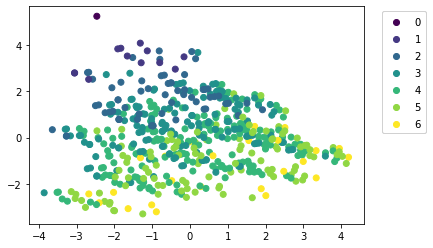

In [21]:
def scatter_encoded(latents, shape,color):
    a = latents.reshape(shape)
    pca = PCA(n_components=2)
    components = pca.fit_transform(a)
    print(type(components))

    fig, ax = plt.subplots(facecolor=(1, 1, 1))
    scatter = ax.scatter(components[:,0], components[:,1], c=color)

    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper left",bbox_to_anchor=(1.04, 1))
    ax.add_artist(legend1)
    fig_name = os.path.join(vis_path, "all_data_encoded")
    fig.savefig(fig_name,bbox_inches='tight')
    plt.show()

scatter_encoded(latents, (number_of_graphs,args.nz), extended)



In [23]:


def prior_validity(n_latent_points,decode_times ):
    Z_train = latents
    Zs_valid = []
    Zs_invalid = []
    Zs_plus_decode = []
    Wrapped_G = []
    z_mean, z_std = np.array(Z_train.mean(0)) ,np.array(Z_train.std(0)) 
    # print(z_mean)
    # print(z_std)
    z_mean, z_std = torch.FloatTensor(z_mean).to(device), torch.FloatTensor(z_std).to(device)
    
    n_valid = 0
    print('Prior validity experiment begins...')
    G = []
    G_valid = []
    G_train = [g for g in train_data]
    pbar = tqdm(range(n_latent_points))
    cnt = 0
    G_valid = []
    G_invalid = []
    n_valid = 0
    for i in pbar:
        cnt += 1
        if cnt == args.infer_batch_size or i == n_latent_points - 1:
            z = torch.randn(cnt, model.nz).to(model.get_device())
        # print(z)
            z = z * z_std + z_mean  # move to train's latent range
        # print(z)
            
            # print(z.cpu().detach().numpy())

            for j in range(decode_times):
                g_batch = model.decode(z)
                for ix,g in enumerate(g_batch):
                    if is_valid_BN(g, graph_args.START_TYPE, graph_args.END_TYPE,args.nvt):
                        n_valid +=1
                        G_valid.append(g)
                        Wrapped_G.append(GraphWrapper(g))
                        Zs_valid.append(z.cpu().detach().numpy()[ix])
                    else:
                        G_invalid.append(g)
                        Zs_invalid.append(z.cpu().detach().numpy()[ix])


            cnt = 0
    return G_valid, G_invalid, Zs_valid, Zs_invalid, Wrapped_G

n_latent_points = 500
decode_times = 10
valid, invalid, Zs_valid, Zs_invalid, Wrapped_G = prior_validity(n_latent_points,decode_times)
sampled_graphs = n_latent_points * decode_times
print(len(valid))
print(len(invalid))


Prior validity experiment begins...


100%|██████████| 500/500 [00:31<00:00, 15.87it/s]

3373
1627


In [24]:
print(number_of_graphs)
print(len(valid))
valid_cleaned = valid.copy()


for g in valid_cleaned:
    to_delete_ids = [v.index for v in g.vs if v["type"] == 0 or v["type"] == 1]
    g.delete_vertices(to_delete_ids)

543
3373


In [25]:
for g in all_data_cleaned:
    to_delete_ids = [v.index for v in g.vs if v["type"] == 0 or v["type"] == 1]
    g.delete_vertices(to_delete_ids)

In [26]:
# TODO
# Hash all_data, create {hash, index} map, map hashes, create array from indexes, np hist
import importlib
import sys
importlib.reload(visualize_util)
all_data_hashes  = {}
# all_data_hashes = {visualize_util.DAG_hash(a):ix for (ix,a) in enumerate(all_data_cleaned) }
# ch = 23456045046006040
for ix,a_d in enumerate(all_data_cleaned):
    h = DAG_hash2(a_d)
    all_data_hashes[h] = ix
    # print(h)
# print(all_data_hashes)


In [27]:
hash_indexes =[]
hashes = []
# hashes = [ visualize_util.DAG_hash(w_g) for w_g in valid]
# print(all_data_hashes)
for w_g in valid_cleaned:
    h = DAG_hash2(w_g)
    if h in all_data_hashes:
        ix = all_data_hashes[h]
    else:
        print("meh")
    # print(h)
    hash_indexes.append(ix)
    hashes.append(h)

# print(len(hashes))
# counter = collections.Counter(hashes)
# c_values = list(counter.values())
# print(c_values)
# hashes.append(visualize_util.DAG_hash(valid[0]))

In [28]:
print(type(valid))
print(all_data_cleaned[0])

<class 'list'>
IGRAPH D--T 4 6 --
+ attr: type (v)
+ edges:
0->1 0->2 0->3 1->2 1->3 2->3


In [29]:
counter = collections.Counter(hashes)
c_values = list(counter.values())

# print(c_values)

In [30]:
print(np.max(c_values))
print(hashes[0])

49
234504003040


3373


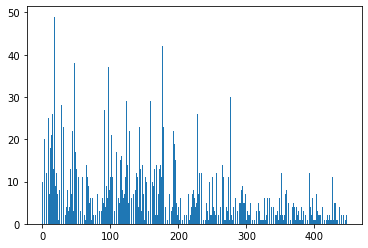

448
5.0


In [31]:
mapped_hashes = [ all_data_hashes[h] if h in all_data_hashes else number_of_graphs for h in hashes]
print(len(mapped_hashes))

counter = collections.Counter(mapped_hashes)
c_values = list(counter.values())
plt.bar([i for i in range(len(c_values))], c_values)
plt.show()
print(len(c_values))
print(np.median(c_values))

In [32]:
print(mapped_hashes[:10])
print(np.max(mapped_hashes))
print(number_of_graphs)
print(list(all_data_hashes.values())[-1])

[373, 488, 374, 110, 334, 348, 427, 112, 130, 290]
542
543
542


In [23]:
# print(all_data_hashes)

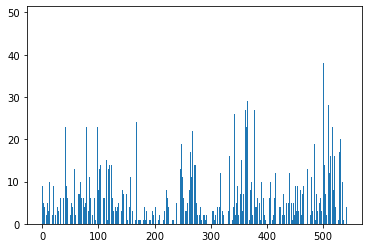

In [33]:
hist1 = np.histogram(mapped_hashes,bins = number_of_graphs)
plt.bar([i for i in range(len(hist1[0]))], hist1[0])
fig_name = os.path.join(vis_path, "frequencies")
plt.savefig(fig_name,bbox_inches='tight', facecolor=(1, 1, 1))
plt.show()


In [36]:
# print(hist1[0])
print(len(hist1[0]))
print(np.argmax(hist1[0]))
all_set = set(all_data_hashes.keys())
valid_set = set(hashes)

missing = all_set - valid_set
print(len(valid_set))
print(len(missing))

543
1
448
95


In [26]:
print(hist1)


(array([1, 0, 0, ..., 0, 0, 1]), array([  344.        ,   344.97595711,   345.95191421, ...,
       28919.04808579, 28920.02404289, 28921.        ]))


In [27]:
importlib.reload(visualize_util)


with open("train_data.pkl", "rb") as f:
    train_data = pickle.load(f)
visualize_util.clear_graphs(train_data)
train_hashes = [DAG_hash2(graph) for graph in train_data]
train_hashes_set = set(train_hashes)


with open("test_data.pkl", "rb") as f:
    test_data = pickle.load(f)
test_data_copy = [g.copy() for g in test_data]

visualize_util.clear_graphs(test_data)
test_hashes = [DAG_hash2(graph) for graph in test_data]
test_hashes_set = set(test_hashes)



with open("valid_data.pkl", "rb") as f:
    valid_data = pickle.load(f)
visualize_util.clear_graphs(valid_data)
valid_hashes = [DAG_hash2(graph) for graph in valid_data]
valid_hashes_set = set(valid_hashes)

cnt_train = 0
cnt_test = 0
cnt_valid = 0
for g in hashes:
    if g in train_hashes:
        cnt_train += 1
    if g in test_hashes:
        cnt_test += 1
    if g in valid_hashes:
        cnt_valid += 1

print(f"Train graphs: {cnt_train}")
print(f"Test graphs: {cnt_test}")
print(f"Valid graphs: {cnt_valid}")

Train graphs: 22
Test graphs: 3
Valid graphs: 2


In [43]:
model.eval()
# train_latents, train_extended = encode_data(model,test_data_copy)
reconstructed_test = [model.encode_decode(model._collate_fn([g]))[0] for g in tqdm(test_data_copy)]
visualize_util.clear_graphs(reconstructed_test)
reconstructed_test_hashes = [DAG_hash2(g) for g in reconstructed_test]



# scatter_encoded(train_latents, (len(test_data), args.nz), train_extended)

100%|██████████| 2929/2929 [02:21<00:00, 20.74it/s]


In [46]:
rec_cnt_train = 0
rec_cnt_valid = 0
rec_cnt_test = 0
rec_cnt_invalid = 0
for g in reconstructed_test_hashes:
    if g in train_hashes:
        rec_cnt_train += 1
    elif g in test_hashes:
        rec_cnt_test += 1
    elif g in valid_hashes:
        rec_cnt_valid += 1
    else:
        rec_cnt_invalid +=1

print(f"Train graphs: {rec_cnt_train}")
print(f"Test graphs: {rec_cnt_test}")
print(f"Valid graphs: {rec_cnt_valid}")
print(f"Invalid graphs: {rec_cnt_invalid}")

Train graphs: 750
Test graphs: 64
Valid graphs: 94
Invalid graphs: 2021


In [47]:
print(f"Train graphs: {rec_cnt_train/len(reconstructed_test_hashes)}")
print(f"Test graphs: {rec_cnt_test/len(reconstructed_test_hashes)}")
print(f"Valid graphs: {rec_cnt_valid/len(reconstructed_test_hashes)}")
print(f"Invalid graphs: {rec_cnt_invalid/len(reconstructed_test_hashes)}")

Train graphs: 0.2560600887674974
Test graphs: 0.021850460908159782
Valid graphs: 0.03209286445885968
Invalid graphs: 0.6899965858654831


In [40]:
# reconstructed_test = [model.encode_decode(model._collate_fn([g]))[0] for g in tqdm(test_data_copy)]

# reconstructed_test = []

# for g in tqdm(test_data_copy):
#     g = model._collate_fn([g])
#     g_r = model.encode_decode(g)[0]
#     print(g_r)
#     visualize_util.clear_graphs([g_r])
#     print(g_r)
#     break

  0%|          | 0/2929 [00:00<?, ?it/s]

IGRAPH D--T 7 10 --
+ attr: type (v)
+ edges:
0->1 1->2 0->2 2->3 0->3 1->4 4->5 0->5 3->6 5->6
IGRAPH D--T 5 4 --
+ attr: type (v)
+ edges:
0->1 1->2 0->3 3->4


In [37]:
uni = np.random.randint(0,542,number_of_graphs)
uni2 = np.random.randint(0,542,number_of_graphs)
m_mean =np.mean(hist1[0][:-2])
m_median =np.median(hist1[0][:-2])
m_std = np.std(hist1[0][:-2])
m_max = np.max(hist1[0][:-2])
m_max_ix = np.argmax(hist1[0])
m_wasser = wasserstein_distance(uni,hist1[0][:-2])
non_zeros = np.count_nonzero(hist1[0][:-2])
versatility = non_zeros/number_of_graphs
uniqueness = (cnt_test + cnt_valid) / len(hashes)
print("Mean: " + str(m_mean))
print("Median: " + str(m_median))
print("Std: " + str(m_std))
print("Max: " + str(m_max))
print("Max index: " + str(m_max_ix))
print("Distance from uniform distribution: " + str(m_wasser))
print("Uni to Uni: " + str(wasserstein_distance(uni,uni2)))
print("Versatility:" + str(versatility))
print("Uniqueness: " + str(uniqueness))
dir_name = Path(p).parent.name

# csv_file_path = "s2.csv"
with open(csv_file_path, 'a+', newline='') as csv_file:
    writer = csv.writer(csv_file, delimiter = ';' )
    writer.writerow([dir_name,args.model, max_epoch,args.batch_size, args.nz, args.hs,  args.beta,m_mean, m_median, m_std,m_max, m_wasser, len(valid),versatility ,sampled_graphs, uniqueness])



NameError: name 'cnt_test' is not defined

In [ ]:
print(hist1[0][:-2])

print(non_zeros)

[5 0 3 ... 3 0 0]
12883


29281


<BarContainer object of 543 artists>

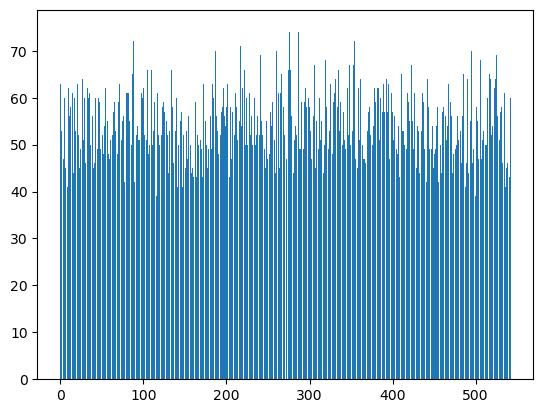

In [ ]:
# print(uni)
print(len(uni))
hist2 = np.histogram(uni, bins=543)
plt.bar([i for i in range(len(hist2[0]))], hist2[0])

(34731, 28)


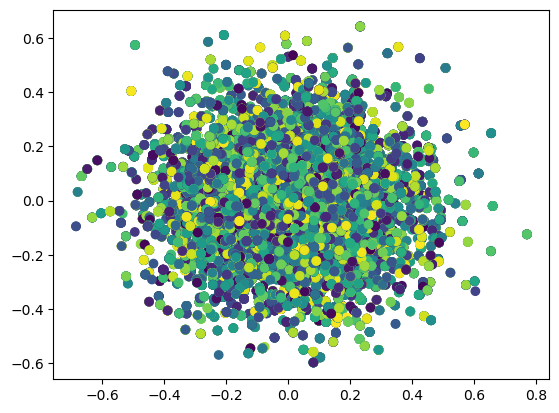

In [ ]:
Zs_valid = np.array(Zs_valid)
print(Zs_valid.shape)

pca = PCA(n_components=2)
sampled_components = pca.fit_transform(Zs_valid)
# plt.scatter(components[:,0], components[:,1], c=extended[:,6])

plt.scatter(sampled_components[:,0], sampled_components[:,1], c=mapped_hashes)
fig_name = os.path.join(vis_path, "sampled")
plt.savefig(fig_name,bbox_inches='tight', facecolor=(1, 1, 1))

# plt.scatter(Zs_valid[:,0], Zs_valid[:,1], c=decode_ix)

17624
119
119


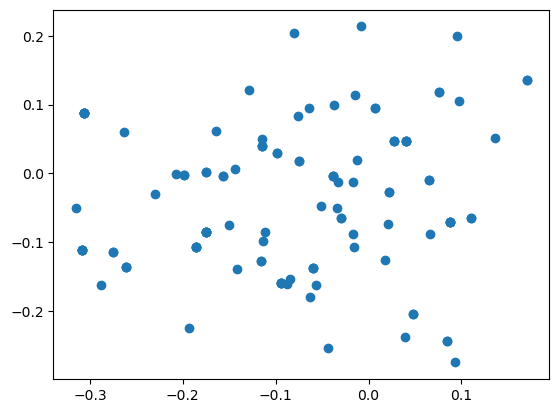

In [ ]:
most_common = counter.most_common(1)[0][0]
print(most_common)

to_print = [ix for ix in range(len(mapped_hashes)) if mapped_hashes[ix] == most_common]
print(len(to_print))
Zs_valid_filtered = [Zs_valid[x] for x in range(len(Zs_valid)) if x in to_print]
print(len(Zs_valid_filtered))
Zs_valid_filtered = np.array(Zs_valid_filtered)
plt.scatter(Zs_valid_filtered[:,0], Zs_valid_filtered[:,1])
fig_name = os.path.join(vis_path, "most_common")
plt.savefig(fig_name,bbox_inches='tight', facecolor=(1, 1, 1))

(15269, 28)


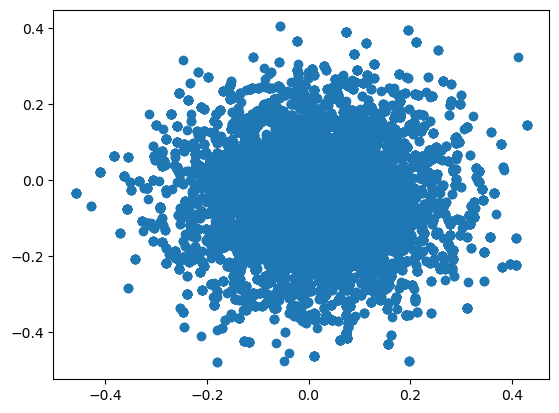

In [ ]:
Zs_invalid = np.array(Zs_invalid)
print(Zs_invalid.shape)
plt.scatter(Zs_invalid[:,0], Zs_invalid[:,1])

torch.Size([1, 28])
torch.Size([1, 28])
torch.Size([1, 28])
torch.Size([1, 28])
torch.Size([1, 28])
torch.Size([1, 28])
torch.Size([1, 28])
torch.Size([1, 28])
torch.Size([1, 28])


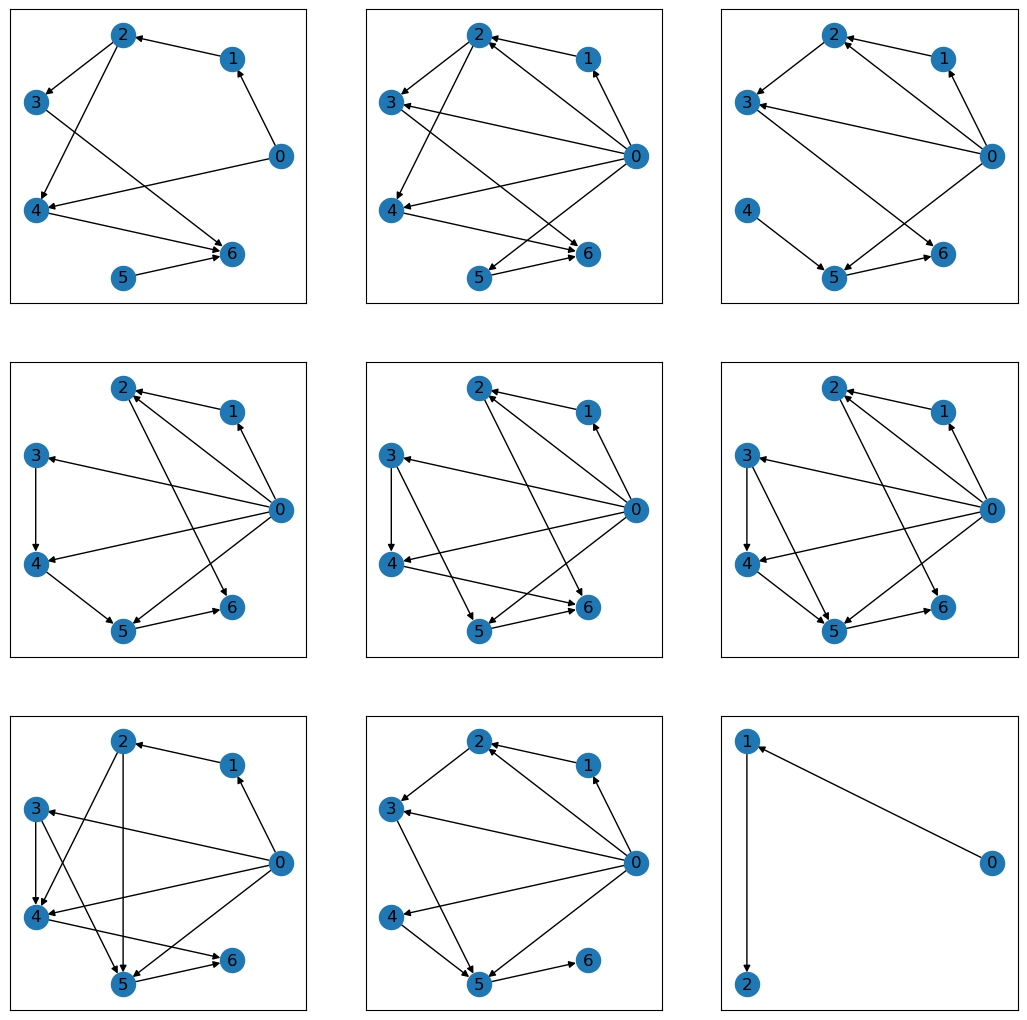

(9, 1, 28)


array([[-4.46821272e-01,  1.06611742e-08],
       [-3.35115910e-01,  6.98690741e-08],
       [-2.23410651e-01,  1.08326494e-08],
       [-1.11705303e-01,  1.85685884e-08],
       [ 5.22574384e-09,  1.79235222e-08],
       [ 1.11705326e-01,  2.91821554e-08],
       [ 2.23410681e-01,  5.13777216e-08],
       [ 3.35115910e-01, -2.70657452e-08],
       [ 4.46821302e-01,  6.04363208e-08]], dtype=float32)

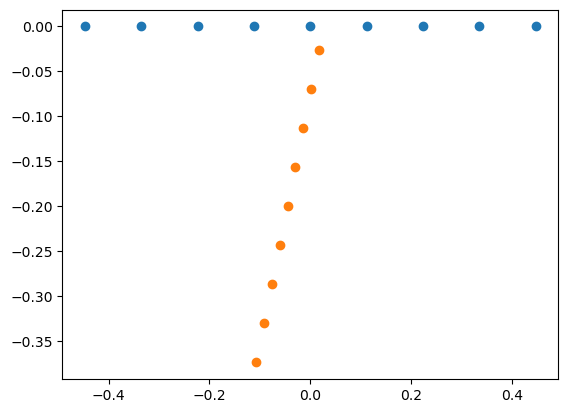

In [ ]:
importlib.reload(visualize_util)
visualize_util.interpolate1_randomPoints(model, latents, 8)

torch.Size([1, 28])


Latent point 0's most common decoding ratio: 1/2: 100%|██████████| 1/1 [00:00<00:00, 859.66it/s]


torch.Size([1, 28])


Latent point 0's most common decoding ratio: 2/4: 100%|██████████| 1/1 [00:00<00:00, 1226.40it/s]


torch.Size([1, 28])


Latent point 0's most common decoding ratio: 2/5: 100%|██████████| 1/1 [00:00<00:00, 1220.69it/s]


torch.Size([1, 28])


Latent point 0's most common decoding ratio: 1/4: 100%|██████████| 1/1 [00:00<00:00, 1176.85it/s]


torch.Size([1, 28])


Latent point 0's most common decoding ratio: 2/5: 100%|██████████| 1/1 [00:00<00:00, 856.33it/s]


torch.Size([1, 28])


Latent point 0's most common decoding ratio: 1/2: 100%|██████████| 1/1 [00:00<00:00, 1062.12it/s]


torch.Size([1, 28])


Latent point 0's most common decoding ratio: 1/4: 100%|██████████| 1/1 [00:00<00:00, 973.38it/s]


torch.Size([1, 28])


Latent point 0's most common decoding ratio: 2/2: 100%|██████████| 1/1 [00:00<00:00, 1134.21it/s]


torch.Size([1, 28])


Latent point 0's most common decoding ratio: 1/3: 100%|██████████| 1/1 [00:00<00:00, 1252.78it/s]


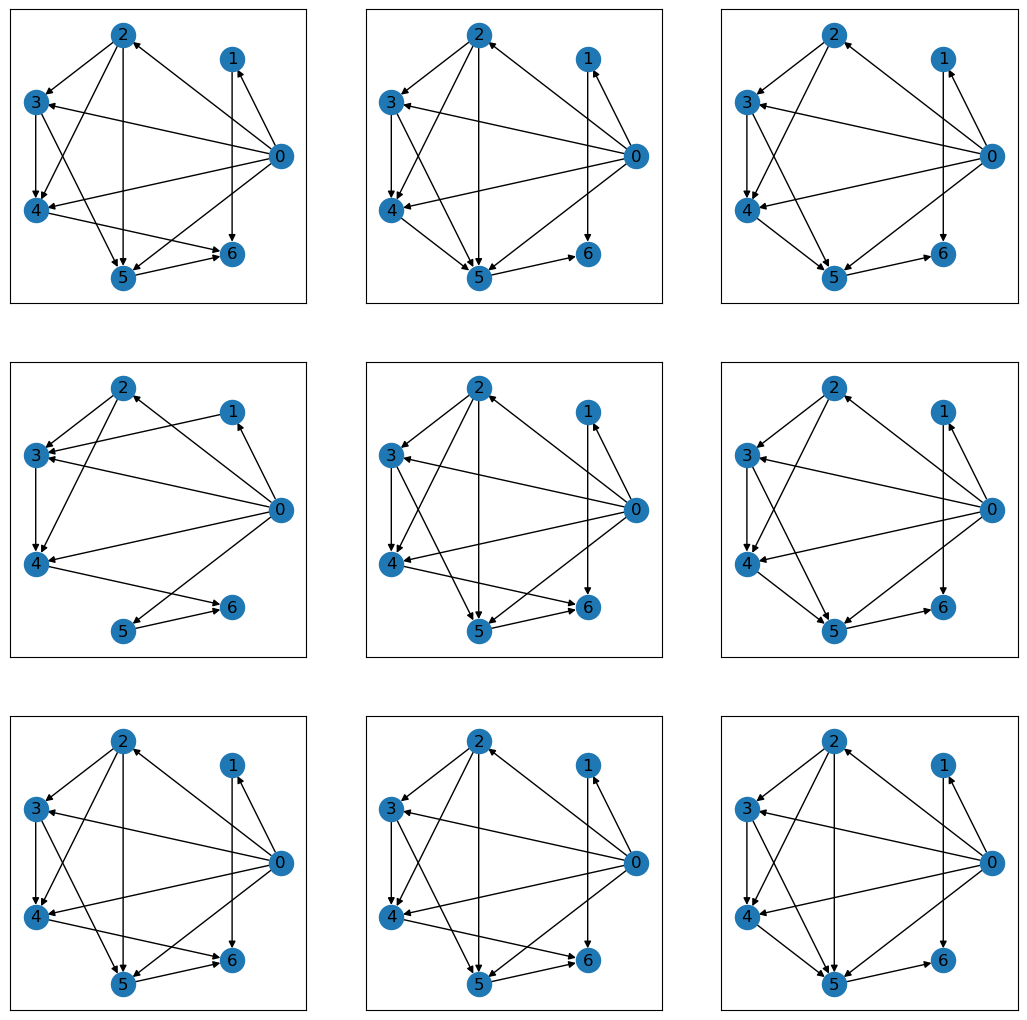

(9, 1, 28)


array([[ 9.4600834e-02,  1.2300654e-08],
       [ 7.0950642e-02,  1.4049502e-08],
       [ 4.7300417e-02,  1.1170768e-08],
       [ 2.3650208e-02,  1.0378582e-08],
       [ 1.2505266e-09,  1.0947127e-08],
       [-2.3650208e-02,  1.5484964e-08],
       [-4.7300421e-02,  1.2580514e-08],
       [-7.0950620e-02,  9.5911963e-09],
       [-9.4600834e-02,  1.3662917e-08]], dtype=float32)

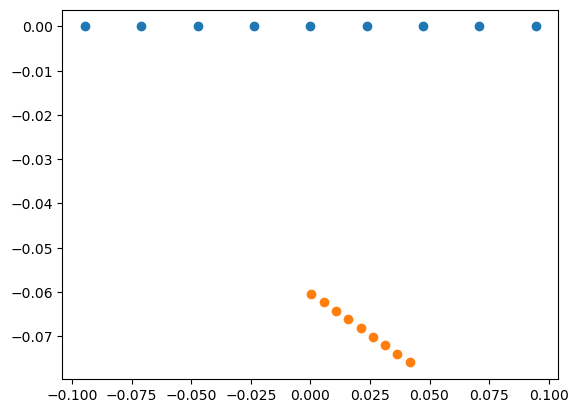

In [ ]:
visualize_util.interpolate2_randomGraphs(model, all_data, latents, 8, 10)

Interpolation experiments around a great circle


Check validity for 11/12: 100%|██████████| 12/12 [00:00<00:00, 1016.80it/s]
Latent point 11's most common decoding ratio: 1/3: 100%|██████████| 12/12 [00:00<00:00, 1515.92it/s]


IGRAPH D--T 7 13 --
+ attr: type (v)
+ edges:
0->1 0->2 2->3 1->3 0->3 3->4 2->4 1->4 0->4 2->5 0->5 4->6 5->6
IGRAPH D--T 7 12 --
+ attr: type (v)
+ edges:
0->1 0->2 2->3 1->3 0->3 3->4 2->4 0->4 2->5 0->5 4->6 5->6
None


AttributeError: 'NoneType' object has no attribute 'to_networkx'

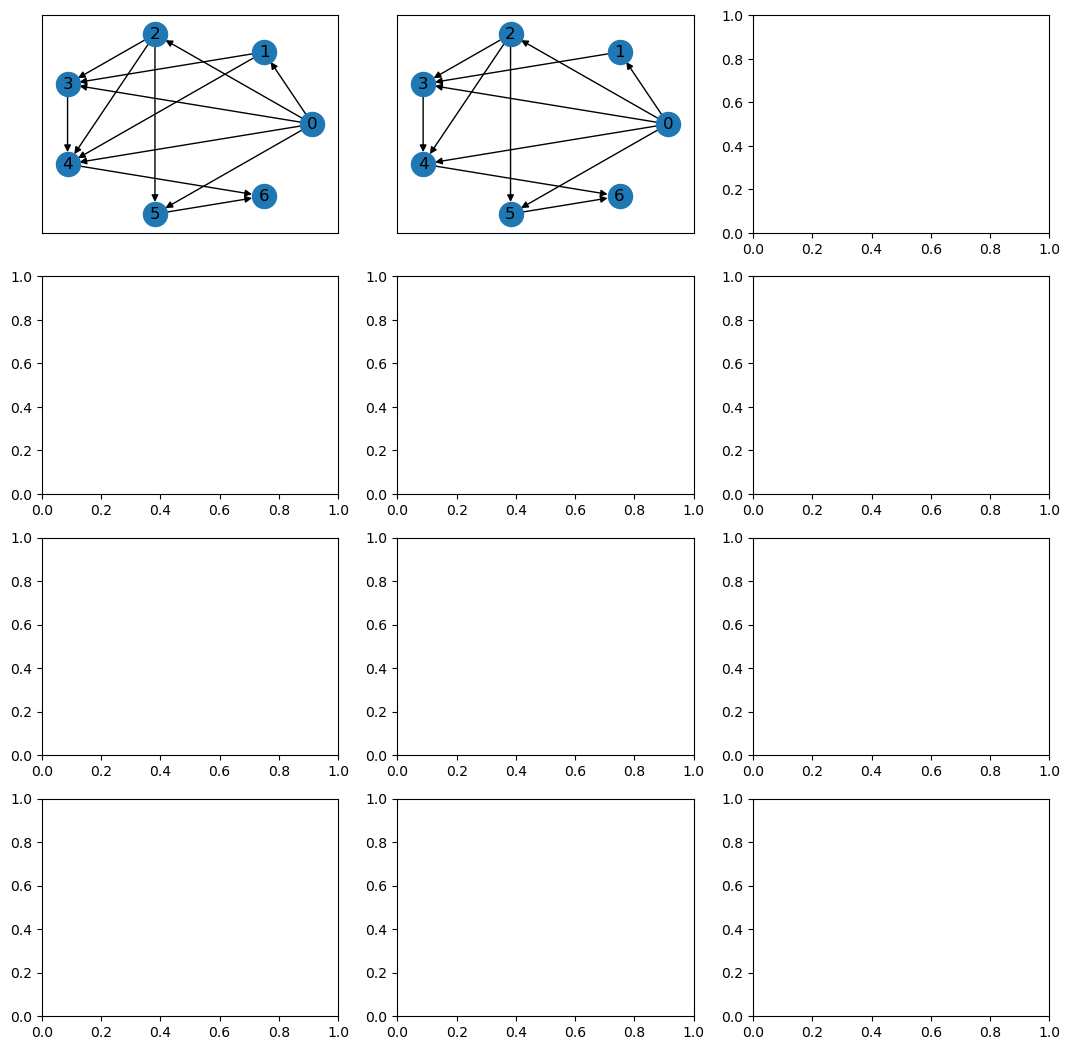

In [ ]:
importlib.reload(visualize_util)
visualize_util.interpolate3_Circle(model,all_data,11,5)